# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [1]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = 'F:\data'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [3]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
sshdyn_1992_1_file = os.path.join(ssh_folder,'ECCO','Version4','Release4','interp_monthly','SSHDYN','SSHDYN_1992_01.nc')
ds = nc4.Dataset(sshdyn_1992_1_file)

lon = ds.variables['i'][:]
lat = ds.variables['j'][:]
sshdyn_1992_1 = ds.variables['SSHDYN'][:]
ds.close()


# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
sshdyn_2017_1_file = os.path.join(ssh_folder,'ECCO','Version4','Release4','interp_monthly','SSHDYN','SSHDYN_2017_01.nc')
ds = nc4.Dataset(sshdyn_2017_1_file)

sshdyn_2017_1 = ds.variables['SSHDYN'][:]

ds.close()

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

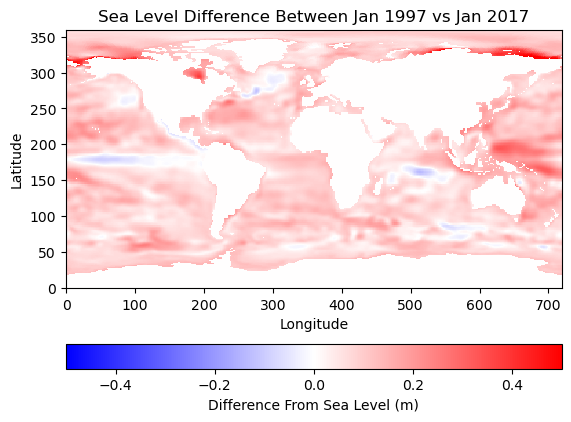

In [4]:
# make a plot of the differences between 2017 and 1992
diff = sshdyn_2017_1[0] - sshdyn_1992_1[0]
fig = plt.figure()

# plot the temperature
plt.pcolormesh(lon, lat, diff, vmin=-0.5, vmax=0.5, cmap='bwr')
colorbar = plt.colorbar(orientation = 'horizontal')
colorbar.set_label('Difference From Sea Level (m)')  # Adjust units if needed

# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Level Difference Between Jan 1997 vs Jan 2017')
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: While sea levels have increased everywhere, the largest increase is in the Arctic ocean. For some reason, we see a sea level fall along the equator west of South America, as well as between Africa and Australia.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

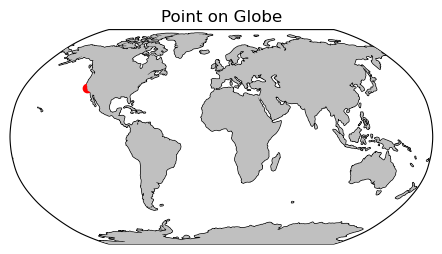

In [5]:
# define the latitude and longitude
cal_lon = -122
cal_lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
row = cal_lon + 360
col = cal_lat + 180

fig = plt.figure(figsize=(12,3))

plt.subplot(1,2,2,projection=ccrs.Robinson())
# ax = plt.axes()
C = plt.plot(cal_lon, cal_lat, 'ro',
                   transform=ccrs.PlateCarree())
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()
plt.gca().set_global()
plt.title('Point on Globe')
plt.show()


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [6]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
# make a list to contain the file names
file_list = []

# loop through the 12 months
for year in range(1992,2018):
    for month in range(1,13):
        file_list.append('SSHDYN_'+str(year)+'_'+'{:02d}'.format(month)+'.nc')

In [7]:
ssh_timeseries = np.zeros((len(file_list),))
for i in range(len(file_list)):
    path = os.path.join(ssh_folder,'ECCO','Version4','Release4','interp_monthly','SSHDYN',file_list[i])
    ds = nc4.Dataset(path)

    sshdyn = ds.variables['SSHDYN'][0]
    ssh_timeseries[i] = sshdyn[row][col]

In [8]:
months = np.arange(len(ssh_timeseries))
dec_yrs = 1992 + months/12

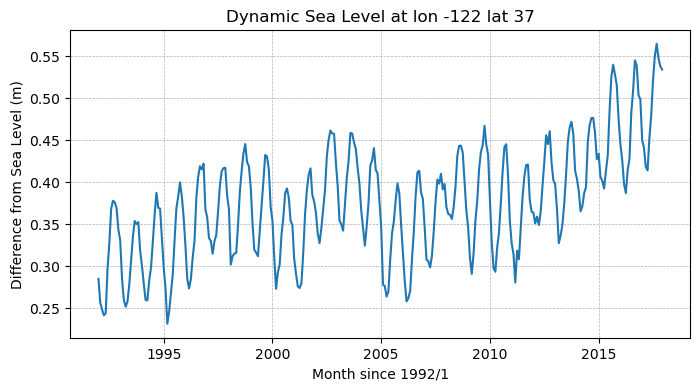

In [9]:
# make a plot of the sea ice timeseries
fig = plt.figure(figsize=(8,4))
plt.plot(dec_yrs, ssh_timeseries)
plt.title('Dynamic Sea Level at lon -122 lat 37')
plt.ylabel('Difference from Sea Level (m)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

In [10]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
ssh_timeseries_global = np.zeros((len(file_list),))
for i in range(len(file_list)):
    path = os.path.join(ssh_folder,'ECCO','Version4','Release4','interp_monthly','SSHDYN',file_list[i])
    ds = nc4.Dataset(path)

    sshdyn = ds.variables['SSHDYN'][0]
    sshdyn_non_zero = sshdyn[sshdyn != 0]
    ssh_timeseries_global[i] = np.mean(sshdyn_non_zero)

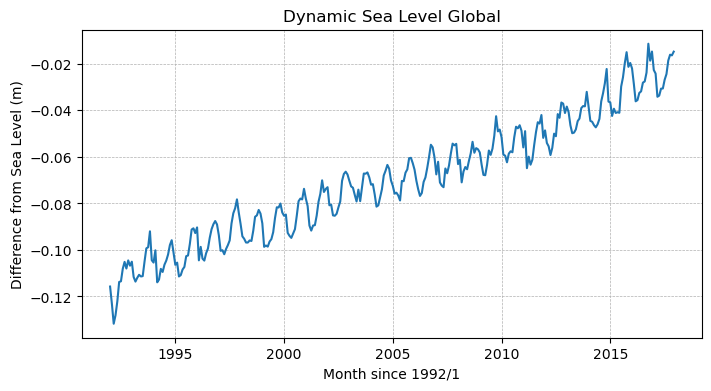

In [11]:
# make a plot of the sea ice timeseries
fig = plt.figure(figsize=(8,4))
plt.plot(dec_yrs, ssh_timeseries_global)
plt.title('Dynamic Sea Level Global')
plt.ylabel('Difference from Sea Level (m)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [12]:
# Compute the trends by fitting a line to each timeseries
line_coefficients_point = np.polyfit(dec_yrs, ssh_timeseries, 1)
line_coefficients_global = np.polyfit(dec_yrs, ssh_timeseries_global, 1)

trend_point = line_coefficients_point[0]
trend_global = line_coefficients_global[0]

# Convert the trends from meters/year to millimeters/year
trend_point_mm_yr = trend_point * 1000
trend_global_mm_yr = trend_global * 1000

# Print the trends rounded to 2 decimal places
print("Trend for California:", round(trend_point_mm_yr, 2), "mm/yr")
print("Trend for Global Mean:", round(trend_global_mm_yr, 2), "mm/yr")

Trend for California: 5.13 mm/yr
Trend for Global Mean: 3.38 mm/yr


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: For some reason it looks like the sea level rise in California is more than double the global mean rate.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

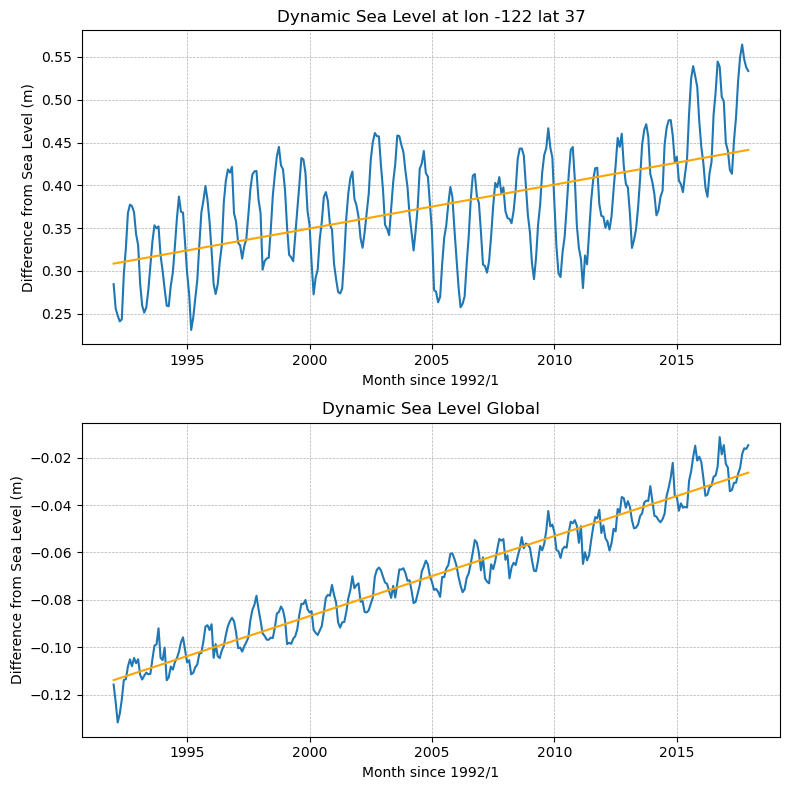

California Trend:  0.0051251716163643055
Global Trend:  0.003376814580817943
California/Global Ratio :  1.517753342300148


In [13]:
# create your plot here
import matplotlib.pyplot as plt

# Assuming you have the following variables defined:
# - dec_yrs: A NumPy array of decimal years
# - ssh_timeseries: A NumPy array of sea surface height values for California
# - ssh_timeseries_global: A NumPy array of sea surface height values for the global mean

# Create a figure with 2 rows and 1 column for subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot California sea surface height on the first subplot
axes[0].plot(dec_yrs, ssh_timeseries)
axes[0].set_title('Dynamic Sea Level at lon -122 lat 37')
axes[0].set_ylabel('Difference from Sea Level (m)')
axes[0].set_xlabel('Month since 1992/1')
axes[0].grid(linestyle='--', linewidth=0.5)

# Plot Global mean sea surface height on the second subplot
axes[1].plot(dec_yrs, ssh_timeseries_global)
axes[1].set_title('Dynamic Sea Level Global')
axes[1].set_ylabel('Difference from Sea Level (m)')
axes[1].set_xlabel('Month since 1992/1')
axes[1].grid(linestyle='--', linewidth=0.5)

# Create the trend lines
trend_line_point = line_coefficients_point[0] * dec_yrs + line_coefficients_point[1]
trend_line_global = line_coefficients_global[0] * dec_yrs + line_coefficients_global[1]

# Plot the trend lines
axes[0].plot(dec_yrs, trend_line_point, color='orange', linestyle='-')
axes[1].plot(dec_yrs, trend_line_global, color='orange', linestyle='-')

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the combined plot
plt.show()

print("California Trend: ", line_coefficients_point[0])
print("Global Trend: ", line_coefficients_global[0])
print("California/Global Ratio : ", line_coefficients_point[0]/line_coefficients_global[0])

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: California's coastal sea level is rising at a rate of 1.52x faster than the global sea level. The variability of California's sea level is also much more aggressive whereas the global sea level is flatter. The two highest years of sea level in California are 2016 and 2017. This seems to coincide with the El Nino oceanographic event which raised sea surface temperatures decreasing the density of water and raising sea levels